# Data Pre-Processing

## To Dos

## Settings & User Input

In [24]:
########################################################################################################################
# Imports & Settings
########################################################################################################################

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import re
import time
import pycountry
from pandas.core.common import flatten
from functools import reduce
import csv
from datetime import datetime

# identification of language used in descriptions
import langid

# translation of descriptions
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from transformers import MarianTokenizer, MarianMTModel

In [2]:
# allow display of all rows (with scrollbar)
pd.set_option("display.max_rows", 10) #pd.set_option("display.max_rows", None)

In [174]:
########################################################################################################################
# User Input
########################################################################################################################

# get todays date as str
today_str = datetime.today().strftime("%Y%m%d")

# source data file paths
transactions_path = '../data/external/transactions.csv'
evaluation_path = '../data/external/evaluation.csv'
items_path = '../data/external/items.csv'
subject_cats_0_path = '../data/external/subject_cats_0.csv'
gbooks_path = '../data/external/gbooks_final.json'

# interim file paths: file storing language flag for item descriptions
description_lang_path = '../data/interim/20210519header_items_description_lang.feather'
description_lang_missing_items_path = '../data/interim/missing_header_items_description_lang.feather'
description_trans_path = '../data/interim/'
language_flg_trans_path = '../data/interim/language_flags_translations.feather'

# pre-processed data file paths (incl. language flags)
transactions_path_pp = '../data/processed/transactions_pp.csv'
items_path_pp = f'../data/processed/{today_str}_items_df.csv'
header_items_path_pp = f'../data/processed/{today_str}_header_items_df.csv'
header_items_lookup_path_pp = f'../data/processed/{today_str}_header_items_lookup_df.csv'

gbooks_volumeInfo_path_pp = '../data/processed/gbooks_volumeInfo_pp.feather'

header_items_20210517_path = '../data/processed/20210517_header_items_df.csv'
header_items_20210519_path = '../data/processed/20210519header_items_df.csv'
header_items_20210519_path = '../data/processed/20210519header_items_df.csv'
header_items_lookup_20210519_path = '../data/processed/20210519header_items_lookup_df.csv'

# seaborn color palette
palette_blue = "Blues_d"
dark_blue = "#011f4b"
middle_blue = "#005b96"
light_blue = "#b3cde0"

# determine: re-calculate certain details
recompute_lg_flg = False # calculated language flags
recompute_desc_lg_flg = False # detect language of description
recompute_desc_trans = False # translate descriptions into english

load_gbooks_data = False # load df containing details from GoogleAPI
recompute_gbooks_volumeInfo = False # volumeInfo per book pulled from GoogleAPI

load_thalia_data = True # load Thalia data 
merge_thalia_data_items_df = True # merge thalia data with items_df

recompute_header_set = True # aggregate details in items_df for items with same title
load_ppgbooks_data_and_merge_with_header = False # load pre-processed google data and merge with items on header level

# set language dictionary to be used throughout the notebook
lang_dict = {'en': 'english', 'de':'german', 'es':'spanish', 'fr': 'french', 'it': 'italian', 'pt':'portuguese'}

## Functions

In [29]:
########################################################################################################################
# Functions
########################################################################################################################

def clean_alt_list(list_):
#     list_ = list_.replace(', ', ',')
    list_ = list_.replace('[', '')
    list_ = list_.replace(']', '')
    return list_


def items_initial_col_processing(items_df, drop_original=True):
    # add col: get len of mt string
#     items_df['mt_len'] = items_df['main topic'].str.len()

    # add col: get first element (top level category) of mt string
#     items_df['mt_0'] = items_df['main topic'].str[0]

    # add col: main topic as set (and converted back to list)
    items_df['mt_cl'] = items_df['main topic'].astype(str).apply(lambda x: list(set(clean_alt_list(x).split(','))))

    # adjust subtopics: set to None if subtopics list is empty
    items_df['st_cl'] = items_df['subtopics'].astype(str).apply(lambda x: list(set(clean_alt_list(x).split(','))))
    items_df.loc[items_df['st_cl']=={''}, 'st_cl'] = None

    # add col: unique combination of main and subtopic
    items_df['mt_st_cl'] = (items_df['st_cl'] + items_df['mt_cl']) #.apply(set)
    
    # drop initial topic cols
    if drop_original:
        items_df = items_df.drop(columns=['main topic', 'subtopics'])
    
    return items_df


def tr_initial_col_processing(transactions_df):
    # add col: get click / basket / order flag
    transactions_df['click_flg'] = np.where(transactions_df['click'] > 0, 1, 0)
    transactions_df['basket_flg'] = np.where(transactions_df['basket'] > 0, 1, 0)
    transactions_df['order_flg'] = np.where(transactions_df['order'] > 0, 1, 0) 
    
    return transactions_df


def extract_gbook_volumeInfo(data, target_keys):

    # initialize final details df
    volumeInfo_df = pd.DataFrame()
    total = len(data)

    for index, row in data.iterrows():
    
        # print progress report
        if int(index%1000) == 0:
            print(f'{index}/{total}')
    
        # extract volumInfo if given
        if row["items"]:
            for item in row["items"]:

                available_keys = list(item['volumeInfo'].keys())
    #             print(f'available_keys: {available_keys}')

                extraction_keys = list(frozenset(available_keys).intersection(target_keys))
    #             print(f'extraction keys: {extraction_keys}')

                volumeInfo_item_df = pd.DataFrame(item).loc[extraction_keys,'volumeInfo']
                volumeInfo_item_df = pd.DataFrame(volumeInfo_item_df).transpose()
                volumeInfo_item_df["itemIdx"] = row["itemIdx"]
    #             display(volumeInfo_item_df)
    #             print()

                volumeInfo_df = pd.concat([volumeInfo_df,volumeInfo_item_df])

    # reset index of volumeInfo df
    volumeInfo_df.reset_index(inplace=True)
    volumeInfo_df = volumeInfo_df.drop(columns='index')  
    
    return volumeInfo_df 


def remove_special_characters(list_):
#     list_ = re.sub(r'^\W+', r'', list_) #removes leading non-alphanumerics, e.g. ",william shakespeare"

    # Remove punctuation & special characters
#     list_ = re.sub(r'[®★✝•„“»«¡”：‚●♥‘…›<,\.!¿?\"\(\)\'\:#]','',list_)
    list_ = re.sub(r'[®★✝•„“»¡”：‚●♥‘…›<,\.!¿?\"\(\)\'\:#]','',list_)
    list_ = re.sub(r'-',' ',list_)
    return list_


    "    list_ = re.sub(r'-',' ',list_)\n",


def remove_next_sign(list_):
#     list_ = re.sub(r'^\W+', r'', list_) #removes leading non-alphanumerics, e.g. ",william shakespeare"

    # Remove punctuation & special characters
    list_ = re.sub(r'[\n]','',list_)
    
    return list_

def remove_nontitle_substrings(list_):
    list_ = str(list_)

    # type of book
    for book_type in ['taschenbuch','hardcover','hardback']:
        list_ = re.sub(f'\(.*{book_type}.*\)?','',list_) #remove all content within brackets
        list_ = re.sub(f'-\s*(\w*\s*){book_type}.*','',list_)
        list_ = re.sub(f':.*{book_type}.*','',list_)
        list_ = re.sub(f'(.*{book_type}[\w\d\s]*):','',list_)
        list_ = re.sub(f'[(special)(book)(edition)\s*]*{book_type}\s*[(special)(book)(edition)\s*]*','',list_)
        list_ = re.sub(f'{book_type}','',list_)
        
    # (light novel)
    list_ = re.sub(f'(light novel)','',list_)
    list_ = re.sub(f'\(novel\)','',list_)
    
    # (edition)
    list_ = re.sub(f'\(.*edition.*\)','',list_)  

    return list_


def convert_umlaute(list_):
    list_ = list_.replace("ä","ae").replace("ü","ue").replace("ö","oe")
    return list_


def remove_duplicate_whitespace(list_):
    list_ = re.sub(f' {2,}','',list_)
    return list_


def generate_header_set(items_df):
    """
    generates header set of items that combines attributes of several items with same title that e.g. only differ in itemID
    or other attributes
    > headerID can be used to replace itemID in transactions_df
    """
    # generate header attribute sets from sub-items -> important: generate sets to prevent duplication 
    header_items_author_df = items_df['author'].groupby([items_df.title]).apply(set).reset_index()
    header_items_publisher_df = items_df['publisher'].groupby([items_df.title]).apply(set).reset_index()
    header_items_mtst_df = items_df['mt_st_cl'].groupby([items_df.title]).apply(sum).apply(set).reset_index() # get unique list of topics

    header_items_language_df = items_df['language'].groupby([items_df.title]).apply(set).reset_index()
    header_items_number_pages_df = items_df['number_pages'].groupby([items_df.title]).apply(set).reset_index()
    header_items_recommended_age_df = items_df['recommended_age'].groupby([items_df.title]).apply(set).reset_index()
    header_items_release_date_df = items_df['release_date'].groupby([items_df.title]).apply(set).reset_index()
    header_items_description_df = items_df['description'].groupby([items_df.title]).apply(set).reset_index()
    
    # compile the list of dataframes you want to merge
    header_items_df_lst = [header_items_author_df, header_items_publisher_df, header_items_mtst_df, header_items_language_df,
                           header_items_number_pages_df,header_items_recommended_age_df, header_items_release_date_df,
                           header_items_description_df ]

    # merge all attributes
    header_items_df = reduce(lambda left,right: pd.merge(left,right,on=['title'],
                                                how='outer'), header_items_df_lst)

    # generate new header index
    header_items_df = header_items_df.reset_index().rename(columns={'index':'headerID'})

    # result inspection
    print(f'shape of header_items_df vs. items_df: {header_items_df.shape} vs. {items_df.shape}')
    print(f'cnt of duplicate "title" in header_df: {(header_items_df["title"].value_counts() > 1).sum()}')

#     print(f'\nconverted df:')
#     display(header_items_df[header_items_df['title'].isin(['(Heli-)opolis - Der verhängnisvolle Plan des Weltkoordinators',
#                                                    '13 Kings',
#                                                    'Ära der Lichtwächter'])].head(5))

#     print(f'\noriginal df:')
#     display(items_df[items_df['title'].isin(['(Heli-)opolis - Der verhängnisvolle Plan des Weltkoordinators',
#                                                    '13 Kings',
#                                                    'Ära der Lichtwächter'])].head(5))

    return header_items_df


def clean_thalia_language_flags(list_):
    list_ = re.sub(f' \(Untertitel.*\)','',list_)
    list_ = re.sub(f'Untertitel\s?:','',list_)
    list_ = re.sub(r'\{\'\'\, ','{',list_)
    
    return list_


def clean_set(list_):
    list_ = re.sub(r'\{\'\'\, ','{',list_)
    
    return list_


def unify_set_from_str(list_):
    list_ = re.sub(r'[\{\}\' ]','',list_)
    
    return list_

## Data load & initial pre-processing

### DMC Source Data

In [30]:
########################################################################################################################
# Load Data
########################################################################################################################

# Load the dmc source data

# - clicks/baskets/order over a period of 3M
# - rows: one transaction for single item
transactions_df = pd.read_csv(transactions_path, delimiter='|', sep='.', encoding='utf-8', 
                              quoting=csv.QUOTE_NONE, error_bad_lines=True)

# - list of product ids (subset of products from items_df) to be used for prediction
evaluation_df = pd.read_csv(evaluation_path, sep='.', encoding='utf-8', quoting=csv.QUOTE_NONE, error_bad_lines=True)
print(f'# evaluation items: {evaluation_df.shape}')

items_df_1 = pd.read_csv(items_path, delimiter='|', sep='.', encoding='utf-8')
items_df_2 = pd.read_csv(items_path, delimiter='|', sep='.', encoding='utf-8', quoting=csv.QUOTE_NONE, error_bad_lines=True)
print(f'# items (1): {items_df_1.shape}')
print(f'# items (2): {items_df_2.shape}')

# load category lookup table (manually created)
subject_cats_0 = pd.read_csv(subject_cats_0_path, delimiter=';', encoding='utf-8', 
                             quoting=csv.QUOTE_NONE, error_bad_lines=True)

########################################################################################################################
# Preprocessing for further inspection
########################################################################################################################

# extract list of base cols
initial_cols= list(items_df_1.columns)

# add/pre-process cols: items
items_df_1 = items_initial_col_processing(items_df_1, drop_original=True)
items_df_2 = items_initial_col_processing(items_df_2, drop_original=True)

# add/pre-process cols: transactions
transactions_df = tr_initial_col_processing(transactions_df)

########################################################################################################################
# Inspection of dfs after initial pre-processing
########################################################################################################################

# show dfs after initial pre-processing
print(f'items_df after first pre-processing:')
display(items_df_1.head(2))

print(f'transactions_df after first pre-processing:')
display(transactions_df.head(2))

# evaluation items: (1000, 1)
# items (1): (78030, 6)
# items (2): (78334, 6)
items_df after first pre-processing:


,itemID,title,author,publisher,mt_cl,st_cl,mt_st_cl
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,[YFB],[5AH],"[5AH, YFB]"
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,[AGZ],"[YBG, AGZ, WFA, YNA, 5AJ, YPA, YBL]","[YBG, AGZ, WFA, YNA, 5AJ, YPA, YBL, AGZ]"


transactions_df after first pre-processing:


,sessionID,itemID,click,basket,order,click_flg,basket_flg,order_flg
0,0,21310,1,0,0,1,0,0
1,1,73018,1,0,0,1,0,0


In [31]:
# reset items_df_2 to items_df
items_df = items_df_2

print(items_df.shape)

(78334, 7)


### Pre-Processed Header DF

### [Backlog] Google API Extract

__To do:__
1. reduce to one match per item
2. include details into items_df

#### Data Load & Pre-Processing

In [7]:
if load_gbooks_data:
    # Load the gbooks details (df)
    gbooks_df = pd.read_json(gbooks_path, orient='records')

    # reset index (to simplify later join with items_df)
    if 'index' in gbooks_df.columns:
        gbooks_df = gbooks_df.drop(columns='index')
    gbooks_df.reset_index(inplace=True)
    gbooks_df = gbooks_df.rename(columns={'index':'itemIdx'})

    # get df stats
    print(f'gbooks_df:')
    display(gbooks_df.head())

    print(f'shape gbooks_df: {gbooks_df.shape}')
    print(f'shape items_df: {items_df.shape}\n')

    # inspect distribution ot total items
    # plt.hist(gbooks_df['totalItems'])


In [8]:
if recompute_gbooks_volumeInfo:

    batch_start_index = 40000
    batch_end_index = len(gbooks_df)
    volumeInfo_df = extract_gbook_volumeInfo(gbooks_df.iloc[batch_start_index+1:batch_end_index+1,:],
                                            target_keys=['title','publisher','authors','publishedDate','description','printType',
                                                           'categories','maturityRating', 'language'])
    # inspect head of df
    # display(volumeInfo_df.head())

    # shape
    print(f'shape volumeInfo_df: {volumeInfo_df.shape}\n')

    # get cnt of nas
    print(f'na per col: \n{volumeInfo_df.isna().sum()}\n')

    # value counts specific cols
    for col in ['maturityRating', 'printType','language']:
        display(pd.DataFrame(volumeInfo_df[col].value_counts()).transpose())
        
    # exclude magazines
    volumeInfo_df = volumeInfo_df.loc[volumeInfo_df['printType']=='BOOK',:]
    # volumeInfo_df = volumeInfo_df.drop(columns='printType') #check whether only books in subsequent batches

    # reset index before saving as feather
    volumeInfo_df.reset_index(inplace=True)
    volumeInfo_df = volumeInfo_df.drop(columns='index')
    
    # save table as feather file (for simplified later load)
    gbooks_volumeInfo_path_pp = f'../data/interim/gbooks_volumeInfo_{int(batch_start_index / 1000)}k-{int(batch_end_index / 1000)}k.feather'
    volumeInfo_df.to_feather(gbooks_volumeInfo_path_pp)

#### Testing 

### Thalia data

In [32]:
if load_thalia_data:

    thalia_data_1 = pd.read_pickle('../data/external/thalia_features.pkl')
    thalia_data_2 = pd.read_pickle('../data/external/thalia_features_missing_items.pkl')
    thalia_data = pd.concat([thalia_data_1, thalia_data_2])
    
    print('thalia_data: ', thalia_data.shape)
    print(thalia_data.head(5))

if merge_thalia_data_items_df:
    
    print('items_df: ',items_df.shape)
    items_df = items_df.merge(thalia_data, on='itemID', how='left')
    print('items_df: ',items_df.shape)

thalia_data:  (78326, 9)
   itemID                                        description rating  \
0   21310  \nA brand-new story in the best-selling Prince...      0   
1   73018                                              \n\n       0   
2   19194  \nMare Barrow's world is divided by blood—thos...      4   
3   40250                                               \n\n      0   
4   46107  \nDie Welt der wilden Tiere\nMalen lernen war ...      0   

  number_pages  recommended_age release_date  language thalia_ranking  \
0                 7 - 9 Jahr(e)   2010-11-30  Englisch                  
1          224     ab 8 Jahr(e)   2020-12-02   Deutsch          37543   
2               13 - 17 Jahr(e)   2016-02-03  Englisch                  
3           64    3 - 6 Jahr(e)   2015-06-04   Deutsch          39540   
4           16    3 - 6 Jahr(e)   2019-02-19   Deutsch          35647   

                                           cover_url  
0  https://assets.thalia.media/img/artikel/816c5c...  

## Outlier Detection
- only for __transactions__: remove transactions with suspiciously high #of clicks/basket/order

In [10]:
print('Original shape:', transactions_df.shape)

Original shape: (365143, 8)


c:\users\esthe\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='click'>

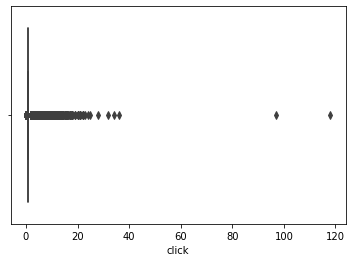

In [11]:
sns.boxplot(transactions_df['click'])

In [12]:
transactions_df = transactions_df[transactions_df['click'] < np.quantile(transactions_df.click, 0.99)]

c:\users\esthe\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='basket'>

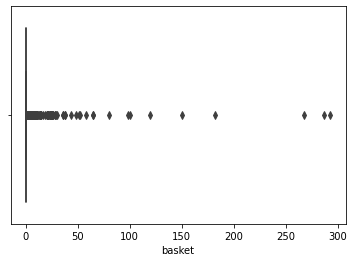

In [13]:
sns.boxplot(transactions_df['basket'])

In [14]:
transactions_df = transactions_df[transactions_df['basket'] < 2]

c:\users\esthe\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='order'>

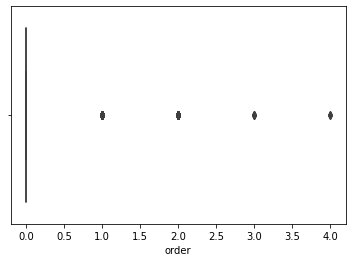

In [15]:
sns.boxplot(transactions_df['order'])

In [16]:
transactions_df = transactions_df[transactions_df['order'] < 2]

In [17]:
print('After outlier removal shape:', transactions_df.shape)

After outlier removal shape: (358086, 8)


## String normalization

__Applied:__
1. conversion to lowercase, e.g. publisher = 'TEKTIME' or 'Tektime' to 'tektime'
2. removal of leading special characters, e.g. ",william shakespeare"
3. conversion of unicode characters (ä,ö,ü)

__No fix yet:__
1. weird entries
    - author: der Authhhhor
    - diverse Autoren, Autoren
3. unicode characters like (à,é,è,°o)

### pre-processing

In [33]:
cols_pp = ['title', 'author', 'publisher']

# convert all strings to lowercase
items_df[cols_pp] = items_df[cols_pp].applymap(lambda s:s.lower() if type(s) == str else s)

for col in cols_pp:
    
    col_cl = col + '_cl'

    # add additional col for pp titles
    items_df[col_cl] = items_df[col]

    # clean strings
    if col == 'title':
        items_df[col_cl] = items_df[col_cl].apply(remove_nontitle_substrings)
    items_df[col_cl] = items_df[col_cl].astype(str).apply(remove_special_characters)
    items_df[col_cl] = items_df[col_cl].apply(convert_umlaute)

    # reduce all spaces in the articles to single spaces
    items_df[col_cl] = items_df[col_cl].apply(remove_duplicate_whitespace)

    # print stats
    col_cnt_unique = items_df[col].nunique()
    col_cl_cnt_unique = items_df[col_cl].nunique()
    print(f'# unique {col} (before preprocessing): {col_cnt_unique} / {len(items_df)}')
    print(f'# unique {col} (after preprocessing): {col_cnt_unique} / {len(items_df)}')
    print(f'# reduction in unique {col}: {col_cnt_unique-col_cl_cnt_unique}\n')
    
# replace original cols by pre-processed cols
items_df = items_df.drop(columns=cols_pp)
items_df = items_df.rename(columns={'title_cl': 'title', 'author_cl': 'author', 'publisher_cl': 'publisher'})

# remove items with missing title after pre-processing
print(f"remove items with missing/empty title after pp: {(items_df['title']=='').sum()}")
items_df = items_df[items_df['title']!='']

# display cleaned df head
display(items_df.head(10))

# unique title (before preprocessing): 72194 / 78334
# unique title (after preprocessing): 72194 / 78334
# reduction in unique title: 245

# unique author (before preprocessing): 35938 / 78334
# unique author (after preprocessing): 35938 / 78334
# reduction in unique author: 164

# unique publisher (before preprocessing): 6936 / 78334
# unique publisher (after preprocessing): 6936 / 78334
# reduction in unique publisher: 30

remove items with missing/empty title after pp: 1


,itemID,mt_cl,st_cl,mt_st_cl,description,rating,number_pages,recommended_age,release_date,language,thalia_ranking,cover_url,title,author,publisher
0,21310,[YFB],[5AH],"[5AH, YFB]",\nA brand-new story in the best-selling Prince...,0,,7 - 9 Jahr(e),2010-11-30,Englisch,,https://assets.thalia.media/img/artikel/816c5c...,princess poppy the big mix up,janey louise jones,penguin random house childrens uk
1,73018,[AGZ],"[YBG, AGZ, WFA, YNA, 5AJ, YPA, YBL]","[YBG, AGZ, WFA, YNA, 5AJ, YPA, YBL, AGZ]",\n\n,0,224,ab 8 Jahr(e),2020-12-02,Deutsch,37543,https://assets.thalia.media/img/artikel/dc6911...,einfach zeichnen step by step,wiebke krabbe,schwager und steinlein
2,19194,[YFH],"[5AP, FBA]","[5AP, FBA, YFH]",\nMare Barrow's world is divided by blood—thos...,4,,13 - 17 Jahr(e),2016-02-03,Englisch,,https://assets.thalia.media/img/artikel/711b74...,red queen 1,victoria aveyard,orion publishing group
3,40250,[YB],"[YF, YBG, 5AC, 5AD, YBL]","[YF, YBG, 5AC, 5AD, YBL, YB]",\n\n,0,64,3 - 6 Jahr(e),2015-06-04,Deutsch,39540,https://assets.thalia.media/img/artikel/f8a160...,meine kindergarten freunde pirat,nan,ars edition gmbh
4,46107,[WFTM],"[WFTM, YBG, YBLN1, WD, YBLD, YBL]","[WFTM, YBG, YBLN1, WD, YBLD, YBL, WFTM]",\nDie Welt der wilden Tiere\nMalen lernen war ...,0,16,3 - 6 Jahr(e),2019-02-19,Deutsch,35647,https://assets.thalia.media/img/artikel/49b027...,mein großes schablonen buch wilde tiere,elizabeth golding,edition michael fischer
5,34217,[FMR],"[FMX, FRX, 1KBB-US-NAK, 3MRBF]","[FMX, FRX, 1KBB-US-NAK, 3MRBF, FMR]",\nRhage und Mary sind Geliebte und Seelenverwa...,5,368,,2017-03-13,Deutsch,83624,https://assets.thalia.media/img/artikel/d308c5...,ewig geliebt,j r ward,heyne taschenbuch
6,31436,[YBG],"[YBLL, 5AD, YBG]","[YBLL, 5AD, YBG, YBG]",\n\n,0,40,ab 4 Jahr(e),2021-07-30,Deutsch,127158,https://assets.thalia.media/img/artikel/5ad225...,meine sticker tiere,nan,ars edition gmbh
7,14576,[YFE],"[YFE, FM, YFH, 5AQ]","[YFE, FM, YFH, 5AQ, YFE]",,,,,NaT,,,,unsterblich 01 tor der daemmerung,julie kagawa,heyne taschenbuch
8,17731,[YFH],"[YFE, FM, YFH, 5AQ]","[YFE, FM, YFH, 5AQ, YFH]","\nIn einer Welt, in der die Menschen von den V...",5,544,14 - 17 Jahr(e),NaT,Deutsch,47235,https://assets.thalia.media/img/artikel/f2e308...,unsterblich 02 tor der nacht,julie kagawa,heyne taschenbuch
9,58723,[YFB],"[1KLSC, 5AM]","[1KLSC, 5AM, YFB]",\nDer Alltag in der kolumbianischen Stadt Cart...,4,160,11 - 99 Jahr(e),1992-03-01,Deutsch,24250,https://assets.thalia.media/img/artikel/c8eb04...,pedro und die bettler von cartagena,ursula hasler,dtv verlagsgesellschaft


### validation

#### title

#### author

#### publisher

## Header-Set 

__Approach:__
1. __[done]__ Generate new header-set with new IDs to unify same books that appear multiple times in the items and transactions table
    a. generate new IDs
    b. unify information
2. __[done]__ Replace the subset IDs in transactions table by superset IDs

3. __[done]__ Pull data on header level from external sources (so far: only thalia data - pulled on item_df level and then aggregated on header_items_df level)

### generation

In [34]:
if recompute_header_set:

    # generate header set with unique ids for "super-items"
    header_items_df = generate_header_set(items_df)
    
    # add headerID to items_df (drop before join if already existent)
    if 'headerID' in items_df.columns:
        items_df = items_df.drop(columns=['headerID'])
    items_df = items_df.merge(header_items_df[['title','headerID']], left_on='title', right_on='title',how='left') 
    display(items_df.head())
    print(f'missing headerIDs in items_df: {items_df["headerID"].isnull().sum()}')

    # generate lookup table
    header_items_lookup_df = items_df[['itemID','headerID']].drop_duplicates()
    print(f'shape of items_df vs. header_items_lookup_df: {items_df.shape} vs. {header_items_lookup_df.shape}')
    
    # clean language tag: replace e.g. {'Deutsch (Untertitel: Deutsch, Englisch)'} -> {'Deutsch'}
    header_items_df['language'] = header_items_df['language'].apply(lambda x: str(x)).apply(clean_thalia_language_flags)

    # clean number_pages
    header_items_df['number_pages'] = header_items_df['number_pages'].apply(lambda x: str(x)).apply(clean_set)
    
    display(header_items_df.head(5))
    
#     # add headerID to transactions_df (drop before join if already existent)
#     if 'headerID' in transactions_df.columns:
#         transactions_df = transactions_df.drop(columns=['headerID'])
#     transactions_df = transactions_df.merge(header_items_lookup_df, left_on='itemID', right_on='itemID',how='left') 

#     # inspect results
#     display(transactions_df.head())
#     print(f'# missing headerIDs in transactions_df: {transactions_df["headerID"].isnull().sum()}')
#     print(f'# unique items in transactions_df: {transactions_df["itemID"].nunique()}')
#     print(f'# unique headers in transactions_df: {transactions_df["headerID"].nunique()}')

shape of header_items_df vs. items_df: (71948, 10) vs. (78333, 15)
cnt of duplicate "title" in header_df: 0


,itemID,mt_cl,st_cl,mt_st_cl,description,rating,number_pages,recommended_age,release_date,language,thalia_ranking,cover_url,title,author,publisher,headerID
0,21310,[YFB],[5AH],"[5AH, YFB]",\nA brand-new story in the best-selling Prince...,0,,7 - 9 Jahr(e),2010-11-30,Englisch,,https://assets.thalia.media/img/artikel/816c5c...,princess poppy the big mix up,janey louise jones,penguin random house childrens uk,45288
1,73018,[AGZ],"[YBG, AGZ, WFA, YNA, 5AJ, YPA, YBL]","[YBG, AGZ, WFA, YNA, 5AJ, YPA, YBL, AGZ]",\n\n,0,224,ab 8 Jahr(e),2020-12-02,Deutsch,37543,https://assets.thalia.media/img/artikel/dc6911...,einfach zeichnen step by step,wiebke krabbe,schwager und steinlein,18751
2,19194,[YFH],"[5AP, FBA]","[5AP, FBA, YFH]",\nMare Barrow's world is divided by blood—thos...,4,,13 - 17 Jahr(e),2016-02-03,Englisch,,https://assets.thalia.media/img/artikel/711b74...,red queen 1,victoria aveyard,orion publishing group,46512
3,40250,[YB],"[YF, YBG, 5AC, 5AD, YBL]","[YF, YBG, 5AC, 5AD, YBL, YB]",\n\n,0,64,3 - 6 Jahr(e),2015-06-04,Deutsch,39540,https://assets.thalia.media/img/artikel/f8a160...,meine kindergarten freunde pirat,nan,ars edition gmbh,38311
4,46107,[WFTM],"[WFTM, YBG, YBLN1, WD, YBLD, YBL]","[WFTM, YBG, YBLN1, WD, YBLD, YBL, WFTM]",\nDie Welt der wilden Tiere\nMalen lernen war ...,0,16,3 - 6 Jahr(e),2019-02-19,Deutsch,35647,https://assets.thalia.media/img/artikel/49b027...,mein großes schablonen buch wilde tiere,elizabeth golding,edition michael fischer,37814


missing headerIDs in items_df: 0
shape of items_df vs. header_items_lookup_df: (78333, 16) vs. (78333, 2)


,headerID,title,author,publisher,mt_st_cl,language,number_pages,recommended_age,release_date,description
0,0,and the word became a story,{the author},{books on demand},"{FM, FL, FN}",{'Englisch'},{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...
1,1,evvai,{cristina polacchini},{lulucom},"{, YFB}",{'Italienisch'},{106},{},{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a..."
2,2,leviathan wakes calibans war abaddons gate no...,{james s a corey},{orbit},"{, FLS}",{'Englisch'},{1792},{},{2019-11-19 00:00:00},"{\nFor the first time in hardcover, the first ..."
3,3,the ultimate vehicle colouring book for kids,{chetna },{westland publications limited},"{, YBG}",{''},{104},{},{2020-08-17 00:00:00},{\n}
4,4,then he ate my boy entrancers,{louise rennison},{harpercollins publishers},"{4Z-GB-ACN, YFM, YFQ}",{'Englisch'},{334},{12 - 15 Jahr(e)},{2006-02-06 00:00:00},"{\nBrilliantly funny, teenage angst author Lou..."


### [Backlog] merge with Google data

In [ ]:
if load_ppgbooks_data_and_merge_with_header:

    # read in preprocessed data
    g_data = pd.read_feather('../data/processed/gbooks_volumeInfo_pp.feather')
    g_data.head(1)
    
    cols_pp = ['title', 'authors', 'publisher']

    # convert all strings to lowercase
    g_data[cols_pp] = g_data[cols_pp].applymap(lambda s:s.lower() if type(s) == str else s)
    
    header_items_df.loc[:, 'author_'] = header_items_df.author.map(lambda x: next(iter(x)))
    header_items_df.loc[:, 'publisher_'] = header_items_df.publisher.map(lambda x: next(iter(x)))
    header_items_df.loc[:, 'release_date_'] = header_items_df.release_date.map(lambda x: next(iter(x)))

In [ ]:
if load_ppgbooks_data_and_merge_with_header:
    for col in cols_pp:

        col_cl = col + '_cl'

        # add additional col for pp titles
        g_data[col_cl] = g_data[col]

        # clean strings
        if col == 'title':
            g_data[col_cl] = g_data[col_cl].apply(remove_nontitle_substrings)
        g_data[col_cl] = g_data[col_cl].astype(str).apply(remove_special_characters)
        g_data[col_cl] = g_data[col_cl].apply(convert_umlaute)

        # reduce all spaces in the articles to single spaces
        g_data[col_cl] = g_data[col_cl].apply(remove_duplicate_whitespace)

        # print stats
        #col_cnt_unique = g_data[col].nunique()
        #col_cl_cnt_unique = g_data[col_cl].nunique()
        #print(f'# unique {col} (before preprocessing): {col_cnt_unique} / {len(items_df)}')
        #print(f'# unique {col} (after preprocessing): {col_cnt_unique} / {len(items_df)}')
        #print(f'# reduction in unique {col}: {col_cnt_unique-col_cl_cnt_unique}\n')

    # replace original cols by pre-processed cols
    g_data = g_data.drop(columns=cols_pp)
    g_data = g_data.rename(columns={'title_cl': 'title', 'author_cl': 'author', 'publisher_cl': 'publisher'})

    # remove items with missing title after pre-processing
    print(f"remove items with missing/empty title after pp: {(g_data['title']=='').sum()}")
    g_data = g_data[g_data['title']!='']

    # display cleaned df head
    display(g_data.head(3))

In [ ]:
#pd.merge(header_items_df, g_data[['title', 'publisher','publishedDate', 'language', 'maturityRating']], left_on=['title','release_date_'], right_on=['title', 'publishedDate'])

## Feature Engineering

### Language flag

__Idea:__
Flag Language of title in order to improve same language recommendations

__Lookup Links:__
1. [stackoverflow:](https://stackoverflow.com/questions/39142778/python-how-to-determine-the-language) comparison of different language detection modules
2. [tds](https://towardsdatascience.com/benchmarking-language-detection-for-nlp-8250ea8b67c) performance evaluation -> recommends __fasttext__

__Note on fasttext:__
- official Python binding module by Facebook
- problems with installation on windows

#### module testing

##### langdetect (=title_ld)
[langdetect](https://pypi.org/project/langdetect/)
- important: use try-catch block to handle e.g. numerics, urls etc
- non-deterministic approach: remember to set seed for reproducible results

##### guess_language (=title_gl)

- Can detect very short samples

##### langid (=title_lg)

- @param instance a text string. Unicode strings will automatically be utf8-encoded 
- @returns a tuple of the most likely language and the confidence score

#### module performance evaluation

### [DEV] Topic Similarity


In [1]:
import pandas as pd
header_items_df = pd.read_csv('../data/processed/20210525_header_items_df.csv')

In [7]:
# creation of sentence embeddings for each category

import pandas as pd
from gensim.models import KeyedVectors

# load embeddings
model = KeyedVectors.load_word2vec_format('../tempData/fetchedData/fasttext.wiki.en.300.vocab_200K.vec')
df = pd.read_json('../tempData/processedData/categories_translated.json', typ='series')

# create cat strings
def cats(row):
    words = ''
    cat_ins = ''
    for char in row:
        cat_ins = cat_ins + char
        try:
            words = words + df.loc[cat_ins].lower() +' '
        except:
            pass
    return words

# calculate averaged sentence embedding
def calc(words):
    summ = 0
    i = 0
    for word in set(words.split()):
        try:
            summ = summ + model[word]
            i = i+1
        except:
            pass
    return summ/i


def f(col):
    s=0
    try:
        for e in col:
            s = s + embs.loc[e][0]
        return s / len(col)
    except KeyError:
        return 0

In [11]:
# loop trough all cats & save as list to be able to save in df
avgs = []
for i in df.index:
    avgs.append([calc(cats(i))])

In [12]:
embs = pd.DataFrame(avgs, index=df.index, columns=['fasttext_emb'])
# embs.head(2)

In [40]:
header_items_df.mt_st_cl = header_items_df.mt_st_cl.str.split(',')

In [29]:
# create list from set
#header_items_df.loc[:, 'mt_st'] = header_items_df.mt_st_cl.map(lambda x: list(x))

In [44]:
header_items_df.loc[:, 'mt_st'] = header_items_df.mt_st_cl.map(lambda x: ' '.join(x).split())

In [45]:
header_items_df.drop('mt_st_cl', axis=1, inplace=True)

In [48]:
# add categorical embeddings
header_items_df['emb_cats'] = header_items_df.apply(lambda x: f(x['mt_st']), axis=1)

### Thalia Data

#### Thalia Language Flag

##### Generate: flag for multi-lingual books

In [35]:
# # test how many entries in set
# print(header_items_df['language'].apply(lambda x: len(eval(x))).value_counts(dropna=False))

# note: 
# - 1 means only one item in set (=but can still be multiple langs separated by comma)
# - 2 means two itmes in set (=generated due to header aggregation)

# generate multi-lingual flag (based on splitting by comma > both due to header agg AND given in Thalia description)
cond_multi_lang = header_items_df['language'].apply(lambda x: len(x.split(','))) > 1
header_items_df['mulit_lang_flg'] = np.where(cond_multi_lang,1,0)

# print value counts for both flags > only use mulit_lang_flg (only 84 items might be mis-classified)
display(header_items_df[['mulit_lang_flg']].value_counts())

# inspect:
display(header_items_df[header_items_df['mulit_lang_flg'] == 1])

mulit_lang_flg
0                 70299
1                  1649
dtype: int64

,headerID,title,author,publisher,mt_st_cl,language,number_pages,recommended_age,release_date,description,mulit_lang_flg
28,28,100 % mallorca ausmalbuch,{lluisa calafat margalida castells},{dix},"{, Y}","{'Deutsch, Englisch, Spanisch'}",{44},{6 - 8 Jahr(e)},{2017-05-01 00:00:00},{\nAusmalbuch zum farbigen Reiseführer! Hier k...,1
121,121,13 kings,"{vs nesby, v s nesby}","{xlibris, xlibris us}","{, FL}","{'Deutsch, Englisch'}",{''},{},{2013-05-03 00:00:00},{\n\nAlbert tritt nach der aufsehenerregenden ...,1
123,123,13 racconti,{vincenzo montevecchi},{lulucom},"{, FL}","{'Deutsch, Italienisch'}",{80},{},{2019-08-29 00:00:00},{\n\n Sette Racconti ist eine Sammlung von sie...,1
124,124,13 reasons why,{jay asher},{penguin lcc us},"{5AN, YXGS, YFB, YXQF}","{'Deutsch, Englisch'}",{69},{},{2018-01-19 00:00:00},{\n\nPräzise auf Thirteen Reasons Why von Jay ...,1
125,125,13 secrets,{michelle harrison},{little brown & co},"{YFCF, YFH}","{'Deutsch, Englisch'}",{113},{},{2008-05-16 00:00:00},"{\n\n Zwei Jugendliche, die das Schicksal zufä...",1
...,...,...,...,...,...,...,...,...,...,...,...
71623,71623,zeitenlos,{ra salvatore},{blanvalet taschenbuchverl},"{, FMB}","{'Deutsch, Englisch'}",{14},{},{2015-07-01 00:00:00},{\nNew York New York – das ist die Welt-Metrop...,1
71678,71678,zero hour,"{will hill, pittacus lore}","{turtleback books, harpercollins publishers}","{YFC, YFD, 5AP, YFG}","{'Deutsch, Spanisch'}",{''},{},{2012-06-22 00:00:00},{\nAusgerechnet während eines Ärztestreiks wir...,1
71684,71684,zero tolerance,{claudia mills},{square fish},"{YFCF, YFS}","{'Deutsch, Französisch'}",{''},{},{2016-07-26 00:00:00},{\n},1
71802,71802,zoo berlin malbuch,{nan},{wimmelbuchverlag},"{YBGC, 5AC, 1DFG-DE-BE}","{'Deutsch, Englisch'}",{32},{3 - 6 Jahr(e)},{2018-07-01 00:00:00},{\nWillkommen im Tierpark Berlin! Im Malbuch k...,1


##### Pre-Process: lang column

,headerID,title,author,publisher,mt_st_cl,language,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_de
0,0,and the word became a story,{the author},{books on demand},"{FM, FL, FN}",{'Englisch'},{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,0,Englisch
1,1,evvai,{cristina polacchini},{lulucom},"{, YFB}",{'Italienisch'},{106},{},{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a...",0,Italienisch


******************************************
#distinct language combos in "language": 50


,index,language
0,{'Englisch'},37464
1,{'Deutsch'},24487
2,{'Spanisch'},3078
3,{''},2440
4,"{'Deutsch, Englisch'}",982
5,{'Italienisch'},888
6,{'Französisch'},758
7,{'Portugiesisch'},355
8,{'Russisch'},123
9,{'Niederländisch'},121


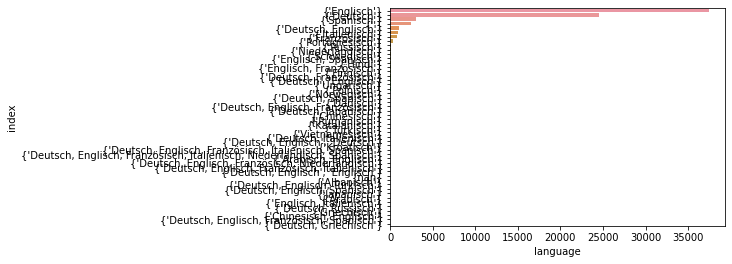

******************************************
#distinct language combos in "item_lang_de": 46


,index,item_lang_de
0,Englisch,37464
1,Deutsch,24488
2,Spanisch,3078
3,"Deutsch, Englisch",1055
4,Italienisch,888
5,Französisch,758
6,Portugiesisch,355
7,Russisch,123
8,Niederländisch,121
9,Schwedisch,118


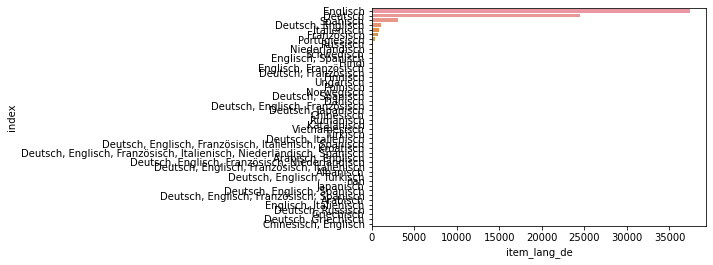

In [36]:
# clean lang column
header_items_df['lang'] = header_items_df['language'].apply(
    lambda x: ', '.join(sorted(list(set(unify_set_from_str(x).split(',')))))
)

# replace "{''}" entries with None
cond_replace_None = (header_items_df['language'] == "{''}")
header_items_df['lang'] = np.where(cond_replace_None, None, header_items_df['lang'])

# rename lang column to item_lang_de
header_items_df = header_items_df.rename(columns={'lang': 'item_lang_de'})
display(header_items_df.head(2))

# inspect cases with multiple languages (!): 
# (a) book is in multiple languages: {'Deutsch, Italienisch'} or {'Deutsch, Englisch (Untertitel: Englisch)'}
# (b) two languages due to merge: {'Deutsch', 'Italienisch'}

pd.set_option("display.max_rows", None)

for lan in ['language','item_lang_de']:
    
    print(f'******************************************')
    lan_dist = pd.DataFrame(header_items_df[lan].value_counts().reset_index())
    lan_dist_sub = lan_dist[lan_dist[lan]>4]
    print(f'#distinct language combos in "{lan}": {len(lan_dist_sub)}')
    display(lan_dist_sub)
    sns.barplot(y='index',x=lan, data=lan_dist_sub, orient='h')
    plt.show()
    
pd.set_option("display.max_rows", 10)

__inspect pre-processing results__

##### Translate: language flag

In [37]:
# load feather file for translation of header language flags
header_items_lang = pd.read_feather(language_flg_trans_path)
display(header_items_lang.head(2))

if 'item_lang_en' in header_items_df.columns:
    header_items_df = header_items_df.drop(columns='item_lang_en') 

# merge english translation of language flag to header items df
header_items_df = header_items_df.merge(header_items_lang, left_on='item_lang_de', right_on='lang_de', how='left')

# drop column with german translation
header_items_df = header_items_df.drop(columns=['item_lang_de','language','lang_de'])
header_items_df = header_items_df.rename(columns={'lang_en': 'item_lang_en'})

# show df
display(header_items_df.head(2))

,lang_de,lang_en
0,Englisch,English
1,Italienisch,Italian


,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en
0,0,and the word became a story,{the author},{books on demand},"{FM, FL, FN}",{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,0,English
1,1,evvai,{cristina polacchini},{lulucom},"{, YFB}",{106},{},{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a...",0,Italian


##### Evaluate: language flag of items in evaluations_df

Note: most book descriptions of books in evaluation_df are in top 5 languages as well:
- de	en	 es	 it	fr	 |   or	an	bn	fi	no	pt
- 425	380	 22	 7	5	 |   2	1	1	1	1	1

#### Thalia Book Descriptions - Pre-Processing

In [38]:
# Preprocessing
header_items_df.loc[:, 'description_'] = header_items_df.description.map(lambda x: next(iter(x)))

# convert all strings to lowercase
header_items_df['description_'] = header_items_df['description_'].apply(lambda s:s.lower() if type(s) == str else s)    
header_items_df['description_'] = header_items_df['description_'].apply(remove_nontitle_substrings)
header_items_df['description_'] = header_items_df['description_'].astype(str).apply(remove_special_characters)
header_items_df['description_'] = header_items_df['description_'].apply(convert_umlaute)
header_items_df['description_'] = header_items_df['description_'].apply(remove_next_sign)

# reduce all spaces in the articles to single spaces
header_items_df['description_'] = header_items_df['description_'].apply(remove_duplicate_whitespace)

# display cleaned df head
display(header_items_df.head(1))

,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_
0,0,and the word became a story,{the author},{books on demand},"{FM, FL, FN}",{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,0,English,at the beginning was the wordand from the word...


In [152]:
# drop initial description
header_items_df.drop('description', axis=1, inplace=True)

In [39]:
header_items_df_backup = header_items_df.copy()

In [111]:
# header_items_df = header_items_df_backup

__Generate df for missing items__

In [112]:
# read in last generated header_df
header_items_df_prev = pd.read_feather('../data/processed/20210524_header_items_df.feather')

# generate unique description / desc_lang / desc_en 
header_items_df_prev = header_items_df_prev[['description_','description_lang', 'description_en']].drop_duplicates()
print('header_items_df_prev: ',header_items_df_prev.shape)
header_items_df_prev.head(2)

# merge both into new: header_items_df_ -> to get language flag and translation
header_items_df_ = header_items_df.merge(header_items_df_prev, on='description_', how='left')
print('header_items_df_: ', header_items_df_.shape)

header_items_df_prev:  (50937, 3)
header_items_df_:  (71948, 14)


In [115]:
# clean descriptions again
cond_clean_desc = (header_items_df_['description_'] == ' ') | (header_items_df_['description_'] == '') | (header_items_df_['description_'] == 'na') | (header_items_df_['description_'] == 'nan')
print('cond_clean_desc: ',cond_clean_desc.sum())
header_items_df_['description_'] = np.where(cond_clean_desc, None, header_items_df_['description_'])

cond_clean_desc:  14119


In [116]:
# inspect missing descriptions
cond_missing_desc = header_items_df_['description_'].notna() & header_items_df_['description_en'].isna() & header_items_df_['description_lang'].isna()
print('cond_missing_desc: ',cond_missing_desc.sum())
header_items_df_missing = header_items_df_[cond_missing_desc] #289 items

cond_missing_desc:  256


In [117]:
header_items_df_.tail(5)

,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_,description_lang,description_en
71943,71943,órbitas míticas volume i,{kerry nietz},{bear publications},"{FM, DNT}",{266},{},{2020-05-30 00:00:00},{\nQuatorze das melhores histórias de Ficção E...,0,Portuguese,quatorze das melhores histórias de ficção espe...,es,quatorze das melhores histórias de ficção spec...
71944,71944,óscar el oso pardo aprende a ser agradecido,{misty black},{berry patch press llc},"{5HCS, YFB, YNMD}",{36},{},{2020-11-05 00:00:00},{\n¡La gratitud nos ayuda a ser felices aún cu...,0,Spanish,la gratitud nos ayuda a ser felices aún cuando...,en,la gratitud nos ayuda a ser felices aún cuando...
71945,71945,ô yrdann 1,{hadrien sins},{books on demand},"{FM, FLS, 5AX}",{332},{ab 12 Jahr(e)},{2020-05-23 00:00:00},{\nUn cadeau des confins de l'espace vient per...,0,French,un cadeau des confins de lespace vient perturb...,fr,A gift from the outer limits of space is comin...
71946,71946,øen læge moreau the island of dr moreau danish...,{herbert george wells},{adizes inst},"{, FL}",{140},{},{2019-06-08 00:00:00},{\nEn skibbrudte herre strandet på en stilleha...,0,Danish,en skibbrudte herre strandet på en stillehavsø...,da,None
71947,71947,út a semmibe,{pócs ervin andrás},{novum publishing},"{, FB}",{''},{},{2018-05-23 00:00:00},{\nA Föld felszíne elpusztult. A megmaradt emb...,0,Hungarian,a foeld felszíne elpusztult a megmaradt emberi...,hu,None


#### Thalia Book Descriptions -  Translation (HEL NLP)

__Approaches tried:__
- tried Google Translator but not suitable as quite unreliable
- will block after 20k requests

__Current Approach:__
- Helsinki NLP Translation Model (ran on Google Colab GPU)

##### Classification of language used for book descriptions

__(A) Old Version for entire df__

In [ ]:
# if recompute_desc_lg_flg:

#     # get start time for performance evaluation
#     start_time_lg = time.time()

#     # classify language of descriptions (note: language flag and description language don't necessarily fit !)
#     # - only choose language of method classify (> ignore confidence score)
#     header_items_df.loc[:,'description_lang'] = header_items_df['description_'].apply(lambda x: langid.classify(str(x))[0])

#     # replace lang flg by none if no description given
#     cond_no_desc = header_items_df['description_'].isna()
#     header_items_df['description_lang'] = np.where(cond_no_desc, None, header_items_df['description_lang'])
#     display(header_items_df.head())

#     # compute execution time
#     end_time_lg = time.time()
#     print(f'exection time langid: {end_time_lg - start_time_lg} seconds') # takes ~ 5 mins to compute

#     # save language flag for description to feather (for simplified reusability)
#     header_items_df[['headerID','description_','description_lang']].to_feather(description_lang_path)
#     print(f'description language exported to: {description_lang_path}')
    
# else:
#     # load stored language flag
#     if 'description_lang' not in header_items_df.columns:
#         description_lang_df = pd.read_feather(description_lang_path).drop(columns='description_')
#         header_items_df = header_items_df.merge(description_lang_df, on='headerID',how='left')
#     display(header_items_df.head(2))

__(B) Alternative Version for missing items__

In [118]:
# # get start time for performance evaluation
# start_time_lg = time.time()

# # classify language of descriptions (note: language flag and description language don't necessarily fit !)
# # - only choose language of method classify (> ignore confidence score)
# header_items_df_missing.drop(columns='description_lang', inplace=True)
# header_items_df_missing.loc[:,'description_lang'] = header_items_df_missing['description_'].apply(lambda x: langid.classify(str(x))[0])

# # replace lang flg by none if no description given
# cond_no_desc = header_items_df_missing['description_'].isna()
# header_items_df_missing['description_lang'] = np.where(cond_no_desc, None, header_items_df_missing['description_lang'])
# display(header_items_df_missing.head(2))

# # compute execution time
# end_time_lg = time.time()
# print(f'exection time langid: {end_time_lg - start_time_lg} seconds') # takes ~ 5 mins to compute

# # inspect distribution of languages
# print(header_items_df_missing['description_lang'].value_counts())

# # copy english descriptions
# cond_en_desc = header_items_df_missing['description_lang'] == 'en'
# header_items_df_missing['description_en'] = np.where(cond_en_desc, 
#                                                      header_items_df_missing['description_'],
#                                                      header_items_df_missing['description_en'])
# display(header_items_df_missing.head(2))

# # select descriptions > only required when re-computing translations
# header_items_df_missing_desc = header_items_df_missing[['description_','description_en','headerID','description_lang']]
# header_items_df_missing_desc.reset_index(inplace=True)
# header_items_df_missing_desc.drop(columns='index',inplace=True)
# header_items_df_missing_desc.head(2)

# # save as feather
# header_items_df_missing_desc.to_feather(description_lang_missing_items_path)

# read feather
header_items_df_missing_desc = pd.read_feather(description_lang_missing_items_path)

# merge with computed language descriptions
header_items_df_missing.drop(columns=['description_lang','description_en'], inplace=True)
header_items_df_missing = header_items_df_missing.merge(header_items_df_missing_desc[['headerID','description_lang']], 
                                                        on='headerID', how='left')
print(header_items_df_missing.shape)
display(header_items_df_missing.head(2))

(256, 13)


c:\users\esthe\appdata\local\programs\python\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_,description_lang
0,809,a flying birthday cake,{louis sachar},"{bloomsbury publishing plc, random house}","{, YFB, YFQ}","{128, 96}","{6 - 9 Jahr(e), 5 - 7 Jahr(e)}","{1999-09-01 00:00:00, 2010-06-21 00:00:00}","{\nMarvin cannot get to sleep. It's late, the ...",0,English,marvin cannot get to sleep its late the ground...,NaN
1,853,a gift for the children,{nan},{open road media young readers},"{, YF}",{''},{},{2018-12-17 00:00:00},"{\n""It is my sincere desire that this simple p...",0,English,it is my sincere desire that this simple pract...,en


__Validation__

##### Compute translations per language (only select top 5)

In [ ]:
# reset list for testing

# frequent_desc_lang = ['de', 'es', 'fr', 'it', 'pt']
# frequent_desc_lang = ['es']

__Main computation done in Google Colab (GPU) - Read in translated batches & merge to original df__

__(A) Old Version: entire df__

In [130]:
# read in translations for missing items
header_items_df_missing_transl_de = pd.read_feather(description_trans_path + 'de/transl_de_missing_header_items.feather')
header_items_df_missing_transl_fr = pd.read_feather(description_trans_path + 'fr/transl_fr_missing_header_items.feather')
header_items_df_missing_transl_it = pd.read_feather(description_trans_path + 'it/transl_it_missing_header_items.feather')
header_items_df_missing_transl_sp = pd.read_feather(description_trans_path + 'es/transl_es_missing_header_items.feather')

# combine them
header_items_df_missing_transl = pd.concat([header_items_df_missing_transl_de,
                                           header_items_df_missing_transl_fr,
                                           header_items_df_missing_transl_it,
                                           header_items_df_missing_transl_sp 
                                           ])

# make sure unique values are copied
header_items_df_missing_transl = header_items_df_missing_transl[['description_','description_en']].drop_duplicates()
display(header_items_df_missing_transl.head())
print(header_items_df_missing_transl.shape)

,description_,description_en
0,sie wollte niemals zurueckkehren er wollte sie...,she never wanted to return he never wanted to ...
1,christentum und demokratie – fuer den groeßten...,The religion professor in the year 2014 is the...
2,eine unbemannte raumsonde des us militaers ent...,an unmanned space probe by the us militant dis...
3,vollkommen unerwartet werden zwoelf lantis aus...,completely unexpected two lantis from a secure...
4,ob in tiefen waeldern dunklen ruinen oder in e...,whether in deep forests dark ruins or in epic ...


(129, 2)


In [131]:
# set index for merge with original df
header_items_df_missing_ = header_items_df_missing.merge(header_items_df_missing_transl, 
                                                    left_on='description_', 
                                                    right_on='description_', 
                                                    how='left')
print('# duplicated headerIDs after merge: ', (header_items_df_missing_.headerID.value_counts() > 1).sum())
header_items_df_missing_.head(2)

,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_,description_lang,description_en
0,809,a flying birthday cake,{louis sachar},"{bloomsbury publishing plc, random house}","{, YFB, YFQ}","{128, 96}","{6 - 9 Jahr(e), 5 - 7 Jahr(e)}","{1999-09-01 00:00:00, 2010-06-21 00:00:00}","{\nMarvin cannot get to sleep. It's late, the ...",0,English,marvin cannot get to sleep its late the ground...,NaN,NaN
1,853,a gift for the children,{nan},{open road media young readers},"{, YF}",{''},{},{2018-12-17 00:00:00},"{\n""It is my sincere desire that this simple p...",0,English,it is my sincere desire that this simple pract...,en,NaN


In [135]:
# # re-set col for original desc
# header_items_df_missing_['description_'] = header_items_df_missing_['description__x']
# header_items_df_missing_.drop(columns=['description__x','description__y'],inplace=True)

# choose en translations
header_items_df_missing_['description_en'] = np.where(header_items_df_missing_['description_lang'] == 'en', 
                                                     header_items_df_missing_['description_'],
                                                     header_items_df_missing_['description_en'],)

# get list of missing headerIDS
missing_headerIDlist = list(header_items_df_missing_['headerID'])

# remove headerIDs of missing items from original dataframe and concat both dfs
print('header_items_df_: ',header_items_df_.shape)
header_items_df_ = header_items_df_[~header_items_df_['headerID'].isin(missing_headerIDlist)]

# concat header_items_df_ and header_items_df_missing_ (> including new translations)
header_items_df_ = pd.concat([header_items_df_, header_items_df_missing_])
print('header_items_df_: ', header_items_df_.shape)
display(header_items_df_.head(2))

# re-set header_items_df_ to header_items_df
header_items_df = header_items_df_
print('# duplicated headerIDs in final header_items_df: ', (header_items_df.headerID.value_counts() > 1).sum())

header_items_df_:  (71948, 14)
header_items_df_:  (71948, 14)


,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_,description_lang,description_en
0,0,and the word became a story,{the author},{books on demand},"{FM, FL, FN}",{304},{},{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,0,English,at the beginning was the wordand from the word...,en,at the beginning was the wordand from the word...
1,1,evvai,{cristina polacchini},{lulucom},"{, YFB}",{106},{},{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a...",0,Italian,amicizia scuola amore alti e bassi in and out ...,it,friendship school love ups and downs in and ou...


#### Thalia Recommended age

1. bin into children/ teenagers / adults
2. fill empty values with adults

In [139]:
def f(cell):
    cell = [int(x) for x in cell]
    try:
        if min(cell) < 3:
            return 'newborn'
        elif (min(cell) >=12) & (min(cell) <=18):
            return 'teen'
        elif (min(cell) > 7) & (min(cell) <12):
            return 'child'
        elif (min(cell) >=3) & (min(cell) <=7):
            return 'small child'
        else:
            return 'adult'
    except:
        return 'adult'

In [140]:
# get rid of set structure (only get one value)
header_items_df.loc[:, 'recommended_age'] = header_items_df.recommended_age.map(lambda x: next(iter(x)))
header_items_df['rec_age'] = header_items_df.recommended_age.str.findall('\d+')

# TESTING
# header_items_df['rec_age'].apply(lambda x: map(int, x))
# header_items_df.recommended_age.str.replace('ab', )
# header_items_df[header_items_df['recommended_age'].str.contains('5')]

In [141]:
# re-set NaN
header_items_df['rec_age'] = np.where(header_items_df['rec_age'].isna(), ['99'], header_items_df['rec_age'])

# generate new age col
header_items_df['rec_age'] = header_items_df['rec_age'].apply(f)

# inspect results
print(header_items_df.rec_age.value_counts())
display(header_items_df.head(5))

adult          41748
small child    11366
teen            8914
child           8115
newborn         1805
Name: rec_age, dtype: int64


,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_,description_lang,description_en,rec_age
0,0,and the word became a story,{the author},{books on demand},"{FM, FL, FN}",{304},,{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,0,English,at the beginning was the wordand from the word...,en,at the beginning was the wordand from the word...,adult
1,1,evvai,{cristina polacchini},{lulucom},"{, YFB}",{106},,{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a...",0,Italian,amicizia scuola amore alti e bassi in and out ...,it,friendship school love ups and downs in and ou...,adult
2,2,leviathan wakes calibans war abaddons gate no...,{james s a corey},{orbit},"{, FLS}",{1792},,{2019-11-19 00:00:00},"{\nFor the first time in hardcover, the first ...",0,English,for the first tim the first three novels in co...,en,for the first tim the first three novels in co...,adult
3,3,the ultimate vehicle colouring book for kids,{chetna },{westland publications limited},"{, YBG}",{104},,{2020-08-17 00:00:00},{\n},0,NaN,None,NaN,NaN,adult
4,4,then he ate my boy entrancers,{louise rennison},{harpercollins publishers},"{4Z-GB-ACN, YFM, YFQ}",{334},12 - 15 Jahr(e),{2006-02-06 00:00:00},"{\nBrilliantly funny, teenage angst author Lou...",0,English,brilliantly funny teenage angst author louise ...,en,brilliantly funny teenage angst author louise ...,teen


#### Thalia Page Numbers

In [142]:
# convert author and publischer to string instead of set
header_items_df['author'] = header_items_df['author'].apply(lambda x: ' ,'.join(list((x))))
header_items_df['publisher'] = header_items_df['publisher'].apply(lambda x: ' ,'.join(list((x))))
header_items_df['mt_st_cl'] = header_items_df['mt_st_cl'].apply(lambda x: ' ,'.join(list((x))))
header_items_df['number_pages'] = header_items_df['number_pages'].apply(lambda x: ' ,'.join(list((x))))
display(header_items_df.head(10))

,headerID,title,author,publisher,mt_st_cl,number_pages,recommended_age,release_date,description,mulit_lang_flg,item_lang_en,description_,description_lang,description_en,rec_age
0,0,and the word became a story,the author,books on demand,"{FM, FL, FN}",{304},,{2018-04-17 00:00:00},{\nAt the beginning was the Word.\nAnd from th...,0,English,at the beginning was the wordand from the word...,en,at the beginning was the wordand from the word...,adult
1,1,evvai,cristina polacchini,lulucom,"{, YFB}",{106},,{2015-08-01 00:00:00},"{\nAmicizia, scuola, amore, alti e bassi, in a...",0,Italian,amicizia scuola amore alti e bassi in and out ...,it,friendship school love ups and downs in and ou...,adult
2,2,leviathan wakes calibans war abaddons gate no...,james s a corey,orbit,"{, FLS}",{1792},,{2019-11-19 00:00:00},"{\nFor the first time in hardcover, the first ...",0,English,for the first tim the first three novels in co...,en,for the first tim the first three novels in co...,adult
3,3,the ultimate vehicle colouring book for kids,chetna,westland publications limited,"{, YBG}",{104},,{2020-08-17 00:00:00},{\n},0,NaN,None,NaN,NaN,adult
4,4,then he ate my boy entrancers,louise rennison,harpercollins publishers,"{4Z-GB-ACN, YFM, YFQ}",{334},12 - 15 Jahr(e),{2006-02-06 00:00:00},"{\nBrilliantly funny, teenage angst author Lou...",0,English,brilliantly funny teenage angst author louise ...,en,brilliantly funny teenage angst author louise ...,teen
5,5,traegt jeans und tennisschuhe,frauke kuehn,rowohlt repertoire,"{YFB, YFY, YXJ, 5AN, 3MPQX, 1DFG, YFCF, YXH, 1...",{124},12 - 15 Jahr(e),{2017-07-21 00:00:00},{\nIm Villenviertel einer Großstadt werden nac...,0,German,im villenviertel einer großstadt werden nachei...,de,In the ville quarter of a big city several rob...,teen
6,6,tripion minaccia dallo spazio,stefano grimaldi,lulucom,"{, FL}",{58},,{2014-07-06 00:00:00},{\nIL GENERE UMANO E' DESTINATO A SCOMPARIRE.....,0,Italian,il genere umano e destinato a scomparirequesto...,it,The human race is destined to disappear thanks...,adult
7,7,und aus dem wort wurde eine geschichte,the author,books on demand,"{FL, FR, FN}",{332},,{2018-04-17 00:00:00},{\nAm Anfang war das Wort. \nUnd aus dem Wort ...,0,German,am anfang war das wort und aus dem wort wurden...,de,at the beginning was the word and the word bec...,adult
8,8,und dann kam joselle,kevin henkes,dtv verlagsgesellschaft,"{YXHB, YFB, 5AN, 5HRB, 1KBB-US-MLW, YXG}",{160},12 - 99 Jahr(e),{1996-04-01 00:00:00},{\n\nNominiert für den Deutschen Jugendliterat...,0,German,nominiert fuer den deutschen jugendliteraturpr...,de,nominated for the German Youth Literature Priz...,teen
9,9,und es gibt sie doch,rolf berlimont,triga,"{FLC, FLU, FLP}",{272},12 - 15 Jahr(e),{2017-12-20 00:00:00},{\nDie Medienberichterstattung über priesterli...,0,German,die medienberichterstattung ueber priesterlich...,de,the media coverage of priestly and episcopal f...,teen


In [156]:
# final data checks
print(header_items_df.shape)
print(header_items_lookup_df.shape)
print(header_items_lookup_df['headerID'].nunique())

(71948, 14)
(78333, 2)
71948


## Export

### Prepare items_df for export

In [ ]:
items_df.drop(columns=['mt_cl','st_cl','rating','thalia_ranking','cover_url'],inplace=True)

In [ ]:
items_df_copy = items_df.copy

In [173]:
# Preprocessing
# items_df.loc[:, 'description'] = items_df.description.map(lambda x: next(iter(x)))

# convert all strings to lowercase
items_df['description'] = items_df['description'].apply(lambda s:s.lower() if type(s) == str else s)    
items_df['description'] = items_df['description'].apply(remove_nontitle_substrings)
items_df['description'] = items_df['description'].astype(str).apply(remove_special_characters)
items_df['description'] = items_df['description'].apply(convert_umlaute)
items_df['description'] = items_df['description'].apply(remove_next_sign)

# reduce all spaces in the articles to single spaces
items_df['description'] = items_df['description'].apply(remove_duplicate_whitespace)

# display cleaned df head
display(items_df.head(1))

,itemID,mt_st_cl,description,number_pages,recommended_age,release_date,language,title,author,publisher,headerID
0,21310,"[5AH, YFB]",a brand new story in the best selling princess...,,7 - 9 Jahr(e),2010-11-30,Englisch,princess poppy the big mix up,janey louise jones,penguin random house childrens uk,45288


### Export of final pre-processed dfs

In [ ]:
pd.set_option("display.max_rows", 100)

In [175]:
# export items_df
items_df.to_csv(items_path_pp)

In [166]:
# # test whether written output looks fine
# pd.read_csv(header_items_lookup_path_pp)